<a href="https://colab.research.google.com/github/mar2nyuedu/colab/blob/main/Copy_of_Mohammed_Rahman_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a Network Intrusion Detection problem. Given a set of network connection records, we need to classify these records as network attacks or regular traffic.

# NSL-KDD is a dataset for evaluating network intrusion detection systems. The dataset is divided into two sets: the training set and the testing set. The dataset contains 43 features for each connection record, such as protocol type, service, flag, and various other statistics. Additionally, it includes a label for each record indicating whether it represents normal traffic or one of the 22 different attack types. There are 125973 records in the training dataset and 22544 records in the test dataset. There are 23 types of attack in the training dataset but 38 types of attack in the test dataset.

# Researchers and developers use the NSL-KDD dataset to train and evaluate intrusion detection models, enabling them to identify and classify network traffic patterns and develop algorithms that can detect and prevent cyber-attacks.

Load and Configure Python Libraries

In [5]:
# Step 1: import the required modules
import pandas as pd
import numpy as np
import warnings
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 


# Ignore all warnings
warnings.simplefilter(action='ignore', category=Warning)

# set pandas columns
pd.set_option('display.max_columns', 50)



Mount Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Training and Test Data

In [7]:
#Read the data from the CSV file

df_train = pd.read_csv('/content/drive/MyDrive/Project/KDDTrainLabeled.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Project/KDDTestLabeled.csv')

print("Training rows:", len(df_train))
print("Testing rows:", len(df_test))

#combine them together in one dataset
df_combined = pd.concat([df_train, df_test]) 

print("combined rows:", len(df_combined))

random_state = 42
# Shuffle the combined dataset
df_combined = df_combined.sample(frac=1, random_state=random_state)

# Split the dataset into training and test sets
train_rows = 125973
df_train = df_combined[:train_rows]
df_test = df_combined[train_rows:]

# Print the number of rows in each DataFrame
print("Training rows:", len(df_train))
print("Testing rows:", len(df_test))



Training rows: 125973
Testing rows: 22544
combined rows: 148517
Training rows: 125973
Testing rows: 22544


Let's view some of the training and test data

In [8]:
df_train.head(5)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
38166,0,udp,domain_u,SF,44,115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,0.0,0.0,0.0,0.0,1.00,0.00,0.40,255,248,0.97,0.01,0.00,0.00,0.0,0.0,0.0,0.0,normal,21
122124,0,tcp,http,SF,248,1273,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.00,0.00,0.00,29,255,1.00,0.00,0.03,0.03,0.0,0.0,0.0,0.0,normal,21
11263,0,tcp,http,SF,310,1957,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.00,0.00,0.00,11,241,1.00,0.00,0.09,0.08,0.0,0.0,0.0,0.0,normal,21
59637,0,tcp,http,SF,240,4664,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4,0.0,0.0,0.0,0.0,1.00,0.00,0.75,18,255,1.00,0.00,0.06,0.01,0.0,0.0,0.0,0.0,normal,21
117914,0,tcp,ftp_data,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,5,1.0,1.0,0.0,0.0,0.24,0.19,0.00,255,64,0.25,0.02,0.01,0.00,1.0,1.0,0.0,0.0,neptune,20


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125973 entries, 38166 to 123668
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  


In [10]:
df_test.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
21310,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,236,12,1.0,1.0,0.0,0.0,0.05,0.06,0.00,255,9,0.04,0.07,0.00,0.00,1.0,1.0,0.0,0.0,neptune,21
114791,0,tcp,ftp_data,SF,59,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.00,0.00,0.00,244,94,0.39,0.02,0.39,0.00,0.0,0.0,0.0,0.0,normal,21
106954,0,udp,private,SF,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,7,0.03,0.21,1.00,0.00,0.0,0.0,0.0,0.0,satan,17
60503,0,tcp,http,SF,171,13014,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,14,0.0,0.0,0.0,0.0,1.00,0.00,0.14,36,255,1.00,0.00,0.03,0.04,0.0,0.0,0.0,0.0,normal,21
8250,0,tcp,Z39_50,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,118,13,1.0,1.0,0.0,0.0,0.11,0.07,0.00,255,13,0.05,0.07,0.00,0.00,1.0,1.0,0.0,0.0,neptune,19


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22544 entries, 21310 to 121958
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell 

Let's check if there is any missing data in both training and test dataset

In [12]:
df_train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [13]:
df_test.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

Wow! Both the training and test data is free from any null values

Let's Visualize the data

In [14]:
def visualize(df_train, df_test,attribute):
  fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(25, 7.5), dpi=100)

  fig.suptitle(f'Counts of Observation Labels', fontsize=25)

  sns.countplot(x=attribute, 
              palette="OrRd_r", 
              data=df_train, 
              order=df_train[attribute].value_counts().index,
              ax=ax1)

  ax1.set_title('Train Set', fontsize=20)
  ax1.set_xlabel(attribute, fontsize=15)
  ax1.set_ylabel('count', fontsize=15)
  ax1.tick_params(labelrotation=90)

  sns.countplot(x=attribute, 
              palette="GnBu_r", 
              data=df_test, 
              order=df_test[attribute].value_counts().index,
              ax=ax2)

  ax2.set_title('Test Set', fontsize=20)
  ax2.set_xlabel(attribute, fontsize=15)
  ax2.set_ylabel('count', fontsize=15)
  ax2.tick_params(labelrotation=90)

  plt.show()

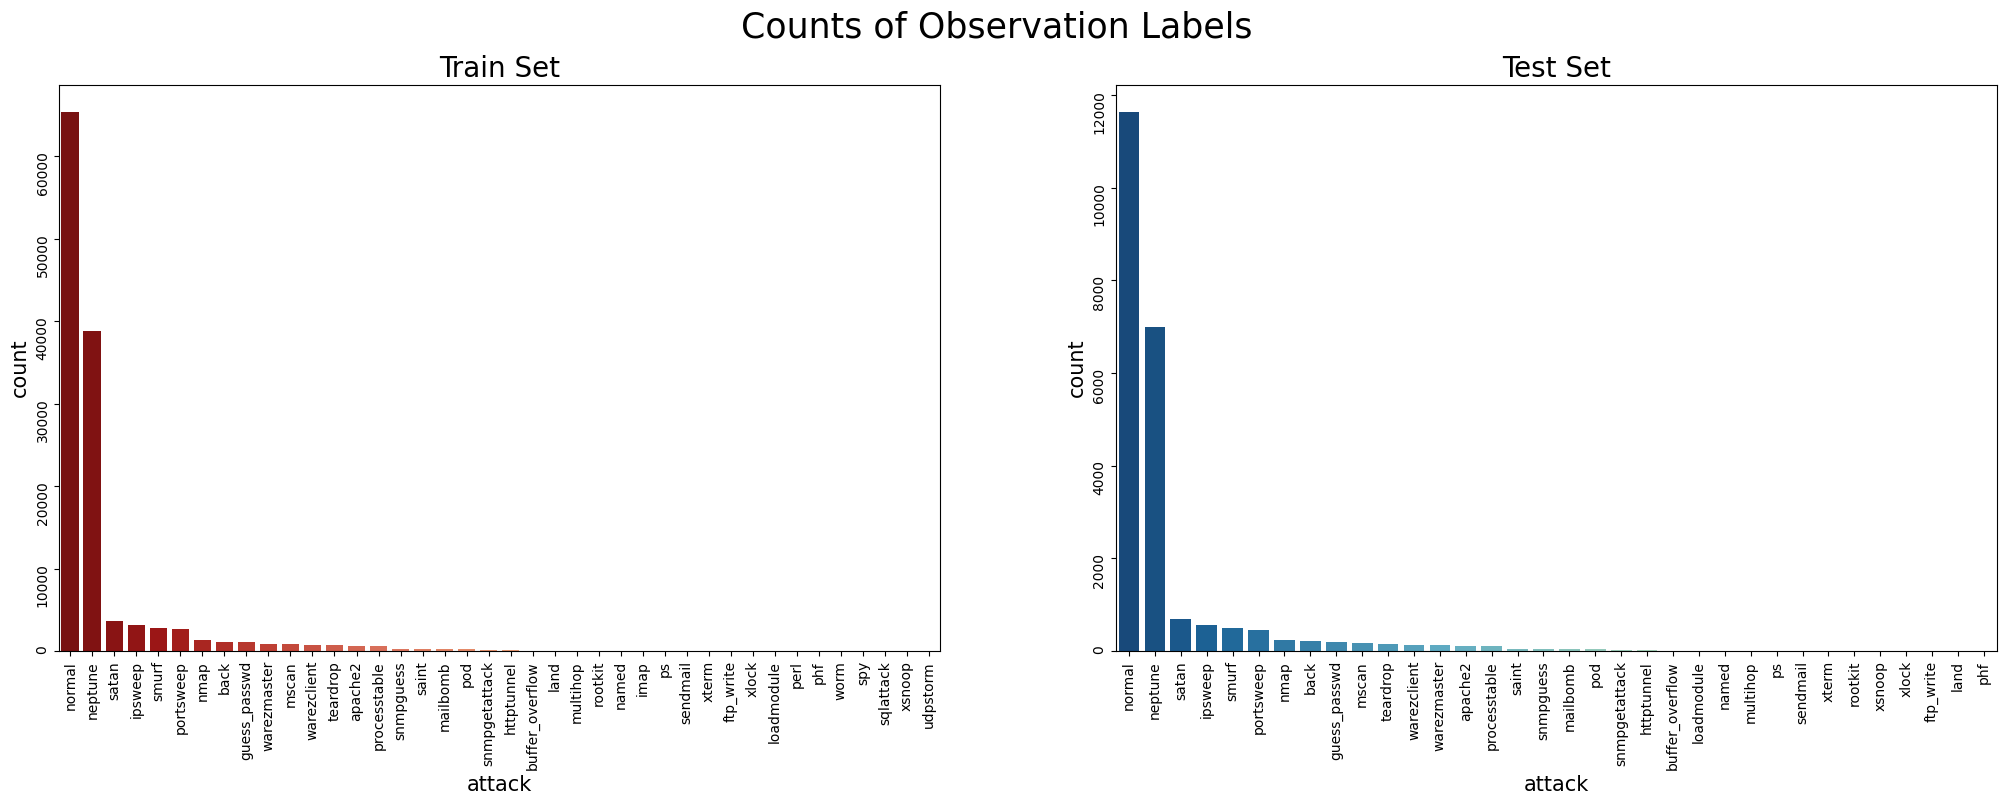

In [15]:
visualize(df_train,df_test,'attack')

Uh-oh! The data is imbalanced in a major way. Most of the connections are either 'normal' or 'neptune' attack both in training and test dataset. That's a training problem for the other categories of attack. The second problem is there are attack categories in the testset (like saint, mailbomb) that do not exist in the training set. How can we train our model without any example? We have to do something to resolve these issues.


In [16]:
#Display the name of attack types in the training dataset
print(df_train['attack'].unique())
#Display the count
print(df_train['attack'].nunique())





['normal' 'neptune' 'satan' 'apache2' 'warezmaster' 'teardrop' 'ipsweep'
 'mscan' 'back' 'warezclient' 'portsweep' 'nmap' 'smurf' 'processtable'
 'guess_passwd' 'httptunnel' 'mailbomb' 'saint' 'snmpguess' 'pod'
 'snmpgetattack' 'xterm' 'land' 'loadmodule' 'worm' 'buffer_overflow'
 'named' 'imap' 'multihop' 'sendmail' 'ps' 'spy' 'xlock' 'perl' 'rootkit'
 'sqlattack' 'xsnoop' 'ftp_write' 'phf' 'udpstorm']
40


In [17]:
#Display the names in test dataset
print(df_test['attack'].unique())
#Display the count
print(df_test['attack'].nunique())

['neptune' 'normal' 'satan' 'warezmaster' 'ipsweep' 'guess_passwd' 'back'
 'portsweep' 'smurf' 'nmap' 'teardrop' 'apache2' 'pod' 'buffer_overflow'
 'mscan' 'httptunnel' 'warezclient' 'processtable' 'mailbomb'
 'snmpgetattack' 'saint' 'snmpguess' 'sendmail' 'ps' 'multihop'
 'loadmodule' 'ftp_write' 'xterm' 'land' 'named' 'rootkit' 'xsnoop'
 'xlock' 'phf']
34


It appears that the attack types in the training and test datasets do not match. To address this, one solution could be to transform the problem into a binary classification task. Specifically, we can create a new column called 'label' and assign the value 'intrusion' to all non-'normal' entries as shown below.

In [18]:
# convert the training data
df_train["label"]=df_train.attack.map(lambda a: "normal" if a == 'normal' else "intrusion")
# drop the original column
df_train.drop('attack',axis=1,inplace=True)
# repeat the same steps on the test data
df_test["label"]=df_test.attack.map(lambda a: "normal" if a == 'normal' else "intrusion")
df_test.drop('attack',axis=1,inplace=True)


Let's Visualize again

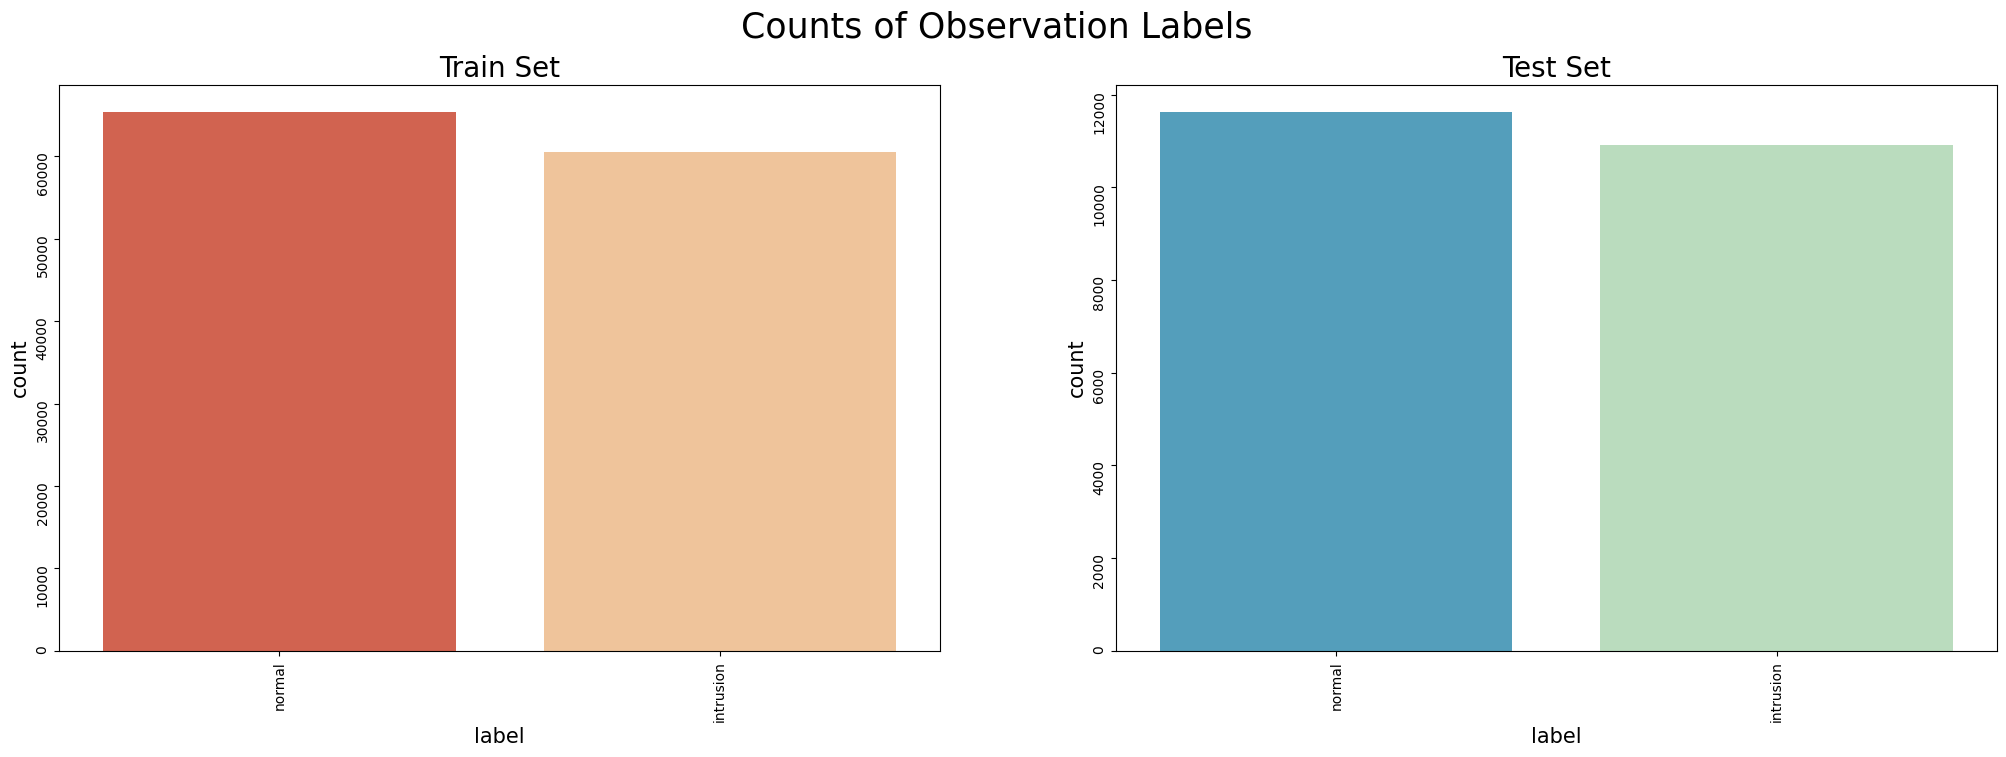

In [19]:
visualize(df_train,df_test,'label')

Let's Identify which other columns has categorical data in them

In [20]:
cat_features_train=[i for i in df_train.columns if df_train.dtypes[i]=='object']
print(cat_features_train)
cat_features_test=[i for i in df_test.columns if df_test.dtypes[i]=='object']
print(cat_features_test)


['protocol_type', 'service', 'flag', 'label']
['protocol_type', 'service', 'flag', 'label']


Keeping the 'label' column aside, we ahve 3 other columns that has categorical data


Let's check the 'protocol_type' column

In [21]:
print(df_train['protocol_type'].unique())
print(df_train['protocol_type'].nunique())
print(df_test['protocol_type'].unique())
print(df_test['protocol_type'].nunique())


['udp' 'tcp' 'icmp']
3
['tcp' 'udp' 'icmp']
3


So, there are the same 3 'protocol_type' values in each set. This is good.

Let's check the 'service' column

In [22]:
print(sorted(df_train['service'].unique()))
print(df_train['service'].nunique())
print(sorted(df_test['service'].unique()))
print(df_test['service'].nunique())

['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois']
70
['IRC', 'X11', 'Z39_50', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'hostnames', 'http', 'http_443', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios

There are 70 and 64 unique 'service' values in training and test dataset. This is a problem for both One-hot encoding and label encoding. We will do label encoding here, so we have to address this problem.

Let's check the 'flag' category

In [23]:
print(sorted(df_train['flag'].unique()))
print(df_train['flag'].nunique())

print(sorted(df_test['flag'].unique()))
print(df_test['flag'].nunique())

['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH']
11
['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH']
11


The 'flag' values match between the two sets

To ensure consistent and accurate replacement of categorical values with numerical codes, we will merge the training and test datasets, perform the string-to-number transformation, and then split them back into their original partitions.

In [24]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()
df_train_copy['train']=1                                                                       
df_test_copy['train']=0                                                                        

joined_df = pd.concat([df_train_copy, df_test_copy])  

le=preprocessing.LabelEncoder()
clm=['protocol_type', 'service', 'flag','label']
for x in clm:
    joined_df[x]=le.fit_transform(joined_df[x])

df_train_copy = joined_df[joined_df['train']==1]                                               
df_test_copy = joined_df[joined_df['train']==0]

drop_cols = ['train']                                      

df_train_copy.drop(drop_cols, axis=1, inplace=True)                                            
df_test_copy.drop(drop_cols, axis=1, inplace=True)

df_train=df_train_copy
df_test=df_test_copy


Let's spot check the 'service' category

In [25]:
print(sorted(df_train['service'].unique()))
print(df_train['service'].nunique())
print(sorted(df_test['service'].unique()))
print(df_test['service'].nunique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
70
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 65, 66, 67, 68, 69]
64


Let's prepare and x and y of both training and test data. We will apply the fit() and tranform() on the x to transform the data between 0 and 1.

In [26]:
x_train=df_train.drop('label',axis=1)
y_train=df_train["label"]

x_test=df_test.drop('label',axis=1)
y_test=df_test["label"]

scaler = MinMaxScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.fit_transform(x_test)

In [27]:
print(x_train)

[[0.         1.         0.17391304 ... 0.         0.         1.        ]
 [0.         0.5        0.34782609 ... 0.         0.         1.        ]
 [0.         0.5        0.34782609 ... 0.         0.         1.        ]
 ...
 [0.         0.5        0.34782609 ... 0.67       0.97       0.95238095]
 [0.         0.5        0.7826087  ... 0.         0.04       1.        ]
 [0.         0.5        0.08695652 ... 0.         0.         0.9047619 ]]


In [28]:
print(x_test)

[[0.         0.5        0.71014493 ... 0.         0.         1.        ]
 [0.         0.5        0.28985507 ... 0.         0.         1.        ]
 [0.         1.         0.71014493 ... 0.         0.         0.80952381]
 ...
 [0.         0.5        0.7826087  ... 0.         0.         1.        ]
 [0.00106126 0.5        0.86956522 ... 0.         0.         0.04761905]
 [0.         1.         0.17391304 ... 0.         0.         0.85714286]]


Let's run only Logistic Regression Model and see the performance

In [29]:
model = LogisticRegression(multi_class='multinomial')
model.fit(x_train, y_train)
   
# Make predictions
predictions = model.predict(x_test)
    
# Calculate metrics
accuracy = accuracy_score(predictions, y_test)
precision = precision_score(predictions, y_test)
recall = recall_score(predictions, y_test)
f1 = f1_score(predictions, y_test)
print(confusion_matrix(y_test, predictions))

print(accuracy)
print(precision)
print(recall)
print(f1)

[[10526   380]
 [  408 11230]]
0.9650461320085166
0.9649424299707854
0.967269595176572
0.9661046111493462


Let's create various models

In [30]:
models = {}
# Logistic Regression
models['Logistic Regression'] = LogisticRegression(multi_class='multinomial')
# Decision Trees
models['Decision Tree'] = DecisionTreeClassifier(max_depth=20)
# Random Forest
models['Random Forest'] = RandomForestClassifier()
# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier(n_neighbors=20)
# Support Vector Machines
models['Support Vector Machine Linear'] = LinearSVC()
models['Support Vector Machine Plonomial'] = SVC(kernel='poly')
models['Support Vector Machine RBF'] =  SVC(kernel='rbf', gamma='scale')
# Naive Bayes
models['Naive Bayes'] = GaussianNB()
# Define the parameter grid for var_smoothing
param_grid = {'var_smoothing': np.logspace(-10, -1, num=10)}

# Create a GridSearchCV instance with the GaussianNB model and the parameter grid
grid_search = GridSearchCV(models['Naive Bayes'], param_grid, scoring='accuracy', cv=5)
# Fit the GridSearchCV instance to the training data
grid_search.fit(x_train, y_train)

# Get the best var_smoothing value
best_var_smoothing = grid_search.best_params_['var_smoothing']
print(f"Best var_smoothing: {best_var_smoothing}")

# Train a GaussianNB model with the best var_smoothing value
models['Naive Bayes']  = GaussianNB(var_smoothing=best_var_smoothing)



Best var_smoothing: 1e-07


Let's apply them

In [31]:
accuracy, precision, recall, specificity, f1, confusion = {}, {}, {}, {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(x_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(x_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    f1[key] = f1_score(predictions, y_test)
    confusion[key] = confusion_matrix(y_test,predictions)
    tn, fp, fn, tp = confusion[key].ravel()
    specificity[key] = tn / (tn + fp)

    

Here are the results side by side

In [32]:
df_comp = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'Specificity','F1', 'Confusion'])
df_comp['Accuracy'] = accuracy.values()
df_comp['Precision'] = precision.values()
df_comp['Recall'] = recall.values()
df_comp['Specificity'] = specificity.values()
df_comp['F1'] = f1.values()
df_comp['Confusion']=confusion.values()

df_comp

,Accuracy,Precision,Recall,Specificity,F1,Confusion
Logistic Regression,0.965046,0.964942,0.967270,0.965157,0.966105,"[[10526, 380], [408, 11230]]"
Decision Trees,0.987713,0.978347,0.997809,0.997708,0.987982,"[[10881, 25], [252, 11386]]"
Random Forest,0.998403,0.997508,0.999397,0.999358,0.998452,"[[10899, 7], [29, 11609]]"
K-Nearest Neighbor,0.995342,0.993470,0.997498,0.997341,0.995480,"[[10877, 29], [76, 11562]]"
Support Vector Machine Linear,0.963316,0.963825,0.965069,0.962773,0.964447,"[[10500, 406], [421, 11217]]"
Support Vector Machine Plonomial,0.994721,0.990806,0.998960,0.998900,0.994866,"[[10894, 12], [107, 11531]]"
Support Vector Machine RBF,0.994455,0.989947,0.999306,0.999266,0.994604,"[[10898, 8], [117, 11521]]"
Naive Bayes,0.889505,0.888984,0.896146,0.890061,0.892551,"[[9707, 1199], [1292, 10346]]"


# ***Now, the overall accuracy is excellent, it appears that all of them  performed really well, although Logistic Regression and Naive Bayes did slightly worse than others.***